In [1]:
# 1. Loading the excel with survey response
# In this analysis, we will focus on analyzing these survey responses with NLP methods.

#### Importing modules
# for basic dataframe and data arrya functions
import pandas as pd
import numpy as np

# for text pre-processing and model development
import wordcloud  # library to generate wordcloud
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import wordnet, stopwords
from textblob import TextBlob

# for plotting and visualization
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import seaborn as sns

# for exception handling
import warnings
import re  # library for regular expression

from pprint import pprint

warnings.simplefilter("ignore", DeprecationWarning)

# Read datasets/papers.csv into papers
response = pd.read_csv(
    r'C:\Users\eskaa\OneDrive - Northern Kentucky University\02 RA - Spring 2021\692 Research Work\Data\HealthCarePrivacyPapers.csv', encoding='latin1')
print(response.head())


                                               Title Month  Year  \
0  An integrated framework for privacy protection...   May  2021   
1  hOCBS: A privacy-preserving blockchain framewo...   May  2021   
2  An End-to-End Authentication Scheme for Health...   Mar  2021   
3  Blockchain-as-a-Utility for Next-Generation He...   Mar  2021   
4  Findings From a Process Evaluation of an Indig...   Mar  2021   

                                              Author  
0                                                NaN  
1                                                NaN  
2                                     Nashwan, Shadi  
3  Almagrabi, Alaa Omran; Ali, Rashid; Alghazzawi...  
4  Firestone, Michelle; Syrette, Jessica; Brant, ...  


In [2]:
def annotate_plot(frame, plot_col, label_col, **kwargs):
    """
    Annotate the plot of a given DataFrame using one of its columns

    Should be called right after a DataFrame or series plot method,
    before telling matplotlib to show the plot.

    Parameters
    ----------
    frame : pandas.DataFrame

    plot_col : str
        The string identifying the column of frame that was plotted

    label_col : str
        The string identifying the column of frame to be used as label

    kwargs:
        Other key-word args that should be passed to plt.annotate

    Returns
    -------
    None

    Notes
    -----
    After calling this function you should call plt.show() to get the
    results. This function only adds the annotations, it doesn't show
    them.
    """

    for label, x, y in zip(frame[label_col], frame.index, frame[plot_col]):
        plt.annotate(label, xy=(x, y), **kwargs)

Year
2016     39
2017     52
2018     50
2019     79
2020    114
2021     27
dtype: int64


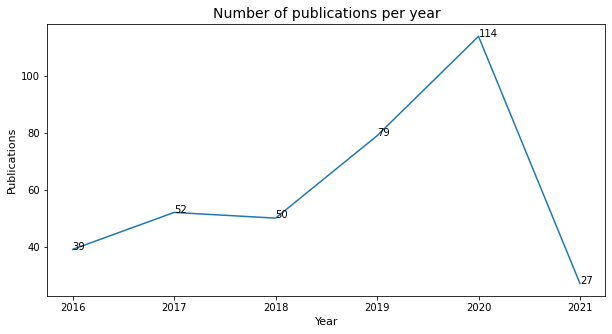

In [3]:
# 3a. Plotting how the opioid research has evolved over time
# A bar plot visualizing the number of publications per year is plotted below
# For this purpose, first the papers are grouped by year and its size is determined
groups = response[response['Year']>2015].groupby('Year')
counts = groups.size()
print(counts)

#x_ticks = papers.groupby('Year').groups.keys()
plt.figure(figsize=(10,5))
ax = counts.plot(kind='line')

for i, j in counts.items():
    ax.annotate(str(j), xy=(i,j))

plt.xlabel('Year', fontsize=11)
plt.ylabel('Publications', fontsize=11)
plt.xticks([2016,2017,2018,2019,2020,2021])
plt.title('Number of publications per year', fontsize=14)
plt.show()

In [4]:
# 3b. Text Pre-processing
my_stopwords = nltk.corpus.stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Master function to POS tagging
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Master function to Lemmatization and Stemming
def lemmatize_text(text):
    filtered_text = [word for word in text.split(' ')
                        if word not in my_stopwords] # remove stopwords
    lemmatized_text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in w_tokenizer.tokenize(' '.join(filtered_text))]
    return ' '.join(lemmatized_text)

response['Title_lemmatized'] = response.Title.apply(lemmatize_text)

# Snowball Stemming
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
# performs text conversion to lowercase, POS tagging & filter and Lemmatization
def clean_response(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    text_token_list = [word_rooter(word) if '#' not in word else word
                        for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

response['Title_processed'] = response.Title_lemmatized.apply(clean_response)

# Master Function for Extracion of Nouns
def extract_nouns(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    length = len(tagged) - 1
    noun_list = list()
    noun_list = [item[0] for item in tagged if item[1][0] == 'N']
    return ' '.join(noun_list)

response['Title_nouns'] = response.Title_lemmatized.apply(extract_nouns)
response.head(10)

,Title,Month,Year,Author,Title_lemmatized,Title_processed,Title_nouns
0,An integrated framework for privacy protection...,May,2021,NaN,An integrate framework for privacy protection ...,integr framework privaci protect iot  appli s...,integrate framework privacy protection IoT  A...
1,hOCBS: A privacy-preserving blockchain framewo...,May,2021,NaN,hOCBS: A privacy-preserving blockchain framewo...,hocb privaci preserv blockchain framework heal...,hOCBS blockchain framework healthcare data lev...
2,An End-to-End Authentication Scheme for Health...,Mar,2021,"Nashwan, Shadi",An End-to-End Authentication Scheme Healthcare...,end end authent scheme healthcar iot system us...,Authentication Scheme Healthcare IoT Systems U...
3,Blockchain-as-a-Utility for Next-Generation He...,Mar,2021,"Almagrabi, Alaa Omran; Ali, Rashid; Alghazzawi...",Blockchain-as-a-Utility Next-Generation Health...,blockchain util next gener healthcar internet ...,Blockchain-as-a-Utility Next-Generation Health...
4,Findings From a Process Evaluation of an Indig...,Mar,2021,"Firestone, Michelle; Syrette, Jessica; Brant, ...",Findings From Process Evaluation Indigenous Ho...,find process evalu indigen holist hous support...,Findings From Process Evaluation Indigenous Ho...
5,Secrecy-ensured NOMA-based cooperative D2D-aid...,Mar,2021,Rajesh Gupta; Sudeep Tanwar; Neeraj Kumar,Secrecy-ensured NOMA-based cooperative D2D-aid...,secreci ensur noma base cooper dd aid fog comp...,fog compute imperfect CSI
6,Security model for protecting intellectual pro...,Mar,2021,Debasis Gountia; Sudip Roy,Security model protect intellectual property s...,secur model protect intellectu properti state ...,Security model property biochip
7,A Bluetooth-Based Architecture for Contact Tra...,Jan,2021,Piergiuseppe Di Marco; Pangun Park; Marco Prat...,A Bluetooth-Based Architecture Contact Tracing...,bluetooth base architectur contact trace healt...,Architecture Contact Tracing Healthcare Facili...
8,Blockchain-based security & privacy for biomed...,Jan,2021,NaN,Blockchain-based security & privacy for biomed...,blockchain base secur privaci biomed healthcar...,security privacy information exchange system
9,Elliptic Curve Cryptography based authenticati...,Jan,2021,K. Sowjanya; Mou Dasgupta; Sangram Ray,Elliptic Curve Cryptography base authenticatio...,ellipt curv cryptographi base authent scheme i...,Curve Cryptography base authentication scheme ...


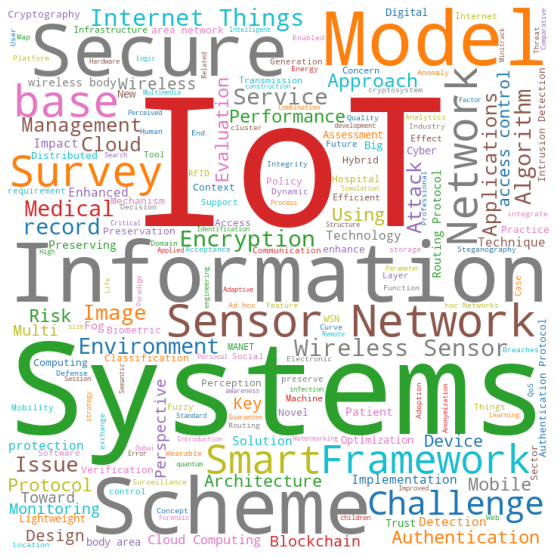

In [5]:
# 3c. Stop Word Filtering and Word Cloud Generation
long_string = " ".join(map(str, response['Title_nouns']))
stopwords = ['privacy','healthcare','security','research','system','use','application','data','health','study','review','method','analysis','consumer','care'] + list(STOPWORDS)
#stopwords = list(STOPWORDS)

# 3d. Generate and visualize a word cloud
wordcloud = wordcloud.WordCloud(stopwords=stopwords, width=720, height=720,background_color="white", colormap="tab10").generate(long_string)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.imshow(wordcloud)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [6]:
# 4.  Prepare the text for LDA (latent Dirichlet allocation) analysis
# For LDA to work, documents need to be converted to simple vector representation. This will be used by LDA to determine the topics.
# So, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary.
# Each entry of a 'document vector' will correspond with the number of times a word occurred in the document.
# Finally, the 10 most common words are plotted based on the outcome of this operation.
# As a check, these words should also occur in the word cloud.

# Helper function

def plot_n_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    plt.figure(figsize=(15,10))
    ax = plt.bar(x_pos, counts, align='center')
    
    for p in ax:
        plt.text(p.get_x() + p.get_width()*offset['center'], 1.01*(p.get_height()),
                '{}'.format(p.get_height()), ha=ha['center'], va='bottom')
    
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


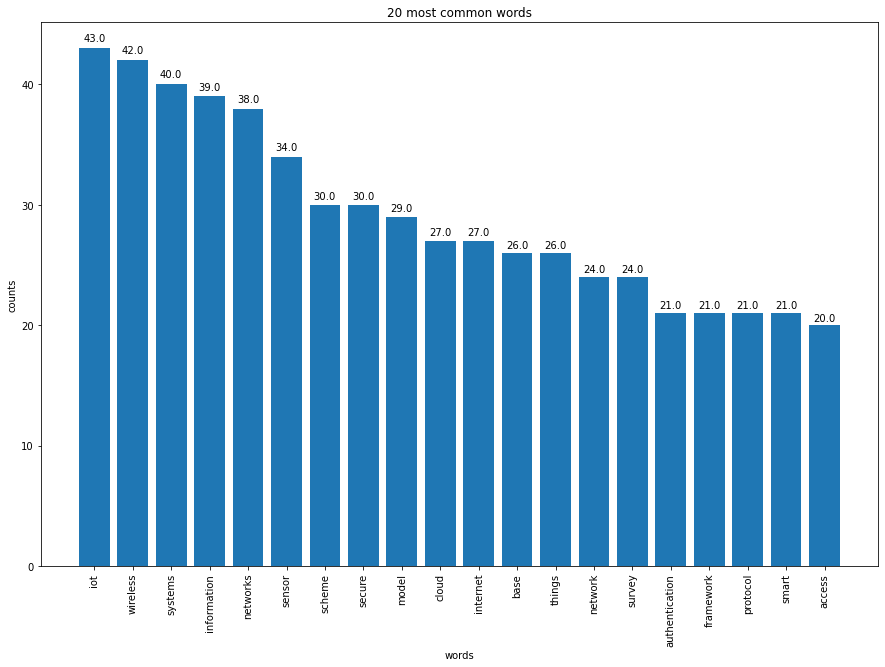

In [7]:
# 4a. Visualise the 30 most common words

vectorizer = CountVectorizer(stop_words=stopwords)
vectorized_data = vectorizer.fit_transform(response['Title_nouns'])
plot_n_most_common_words(vectorized_data, vectorizer)

In [8]:
# 4b. Materialize the sparse data
data_dense = vectorized_data.todense()

# 4b. Compute Sparsity = Percentage of Non-Zero cells
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsity:  0.5703263649922096 %


In [9]:
# 4c. Analysing trends with LDA
# This step would enable us to identify the number of unique topics using the perplexity factor.

# Helper function

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below (Can use any int values)
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit_transform(vectorized_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)


Topics found via LDA:

Topic #0:
authentication, systems, medical, iot, protocols, lightweight, secure, information, protocol, rfid

Topic #1:
applications, cloud, networks, optimization, techniques, dynamic, qos, fog, evaluation, analytical

Topic #2:
survey, systems, smart, implementation, internet, things, iot, evaluation, base, enabled

Topic #3:
model, machine, monitoring, network, secure, intrusion, mobile, detection, performance, card

Topic #4:
encryption, secure, image, using, information, survey, scheme, prediction, applications, disease

Topic #5:
cloud, computing, applications, environment, secure, scheme, service, survey, preserving, model

Topic #6:
information, framework, design, blockchain, algorithm, model, evaluation, communication, exchange, scheme

Topic #7:
model, scheme, medical, internet, things, multi, social, context, approach, hybrid

Topic #8:
wireless, sensor, network, networks, body, area, smart, scheme, base, authentication

Topic #9:
children, model, enha

In [10]:
# 4d. Diagnosing the Model Performance through Log Likelihood and Perplpexity factor

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(vectorized_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vectorized_data))

# See model parameters
print(lda.get_params())

Log Likelihood:  -20572.99187224211
Perplexity:  1717.4313235647633
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [11]:
# 4e. Finding the Best LDA Model through GridSearchCV
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30]}

# Init the Model
search_lda = LDA()

# Init Grid Search Class
model = GridSearchCV(search_lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectorized_data)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_data))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -6151.0804446895645
Model Perplexity:  1132.1122356732385


In [12]:
model.cv_results_

{'mean_fit_time': array([0.3787991 , 0.32262673, 0.36051946, 0.31201129, 0.31140079,
        0.32288523]),
 'std_fit_time': array([0.00547998, 0.00733996, 0.03435602, 0.00905855, 0.00942037,
        0.00812471]),
 'mean_score_time': array([0.01440458, 0.01081705, 0.0136837 , 0.01158867, 0.0121666 ,
        0.01120019]),
 'std_score_time': array([0.00320487, 0.00300805, 0.00427787, 0.00366832, 0.00345998,
        0.00390984]),
 'param_n_components': masked_array(data=[5, 10, 15, 20, 25, 30],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 5},
  {'n_components': 10},
  {'n_components': 15},
  {'n_components': 20},
  {'n_components': 25},
  {'n_components': 30}],
 'split0_test_score': array([ -6205.21052858,  -7787.00126539,  -9186.36919035, -10310.73316839,
        -11487.66017199, -12592.980009  ]),
 'split1_test_score': array([ -6011.56715591,  -7673.47688688,  -9130.64522072, -10419.5213897

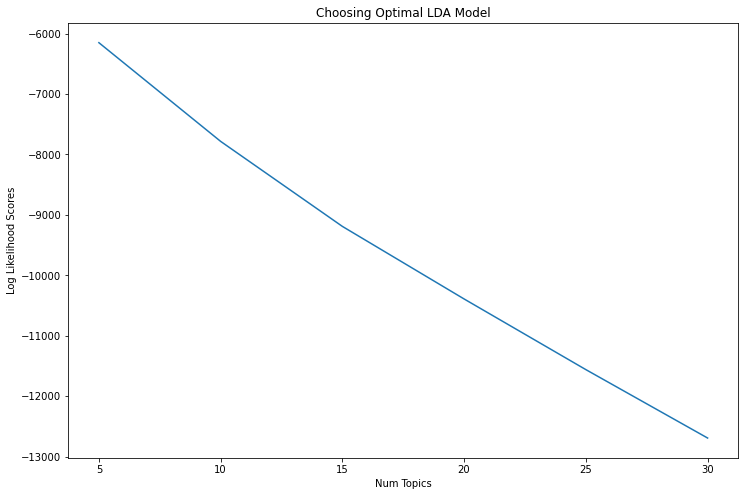

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25, 30]
log_likelihood = [round(gscore) for gscore in model.cv_results_['mean_test_score']]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihood)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.show()

In [14]:
#Topics found for the best fit LDA model
print("Topics found for our Best Fit LDA Model:")
print_topics(best_lda_model, vectorizer, 10)

Topics found for our Best Fit LDA Model:

Topic #0:
iot, control, access, base, authentication, scheme, management, applications, record, network

Topic #1:
information, challenges, towards, cyber, model, risk, survey, infrastructure, applications, evaluation

Topic #2:
wireless, networks, sensor, secure, body, protocol, routing, medical, computing, cloud

Topic #3:
smart, systems, iot, detection, model, things, internet, framework, base, survey

Topic #4:
scheme, internet, things, cloud, network, systems, environment, encryption, computing, using


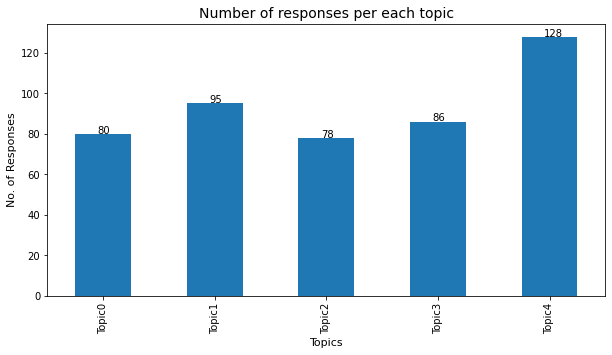

In [15]:
docsPerTopic = best_lda_model.transform(vectorized_data)
docsPerTopic = pd.DataFrame(docsPerTopic, columns=["Topic"+str(i) for i in range(best_lda_model.n_components)])
most_likely_topics = docsPerTopic.idxmax(axis=1)
counts = most_likely_topics.groupby(most_likely_topics).count()

plt.figure(figsize=(10,5))
ax=counts.plot(kind='bar')

for p, label in zip(ax.patches, counts.values):
    ax.annotate(label, (p.get_x()+0.2, p.get_height()+0.3))

plt.xlabel('Topics', fontsize=11)
plt.ylabel('No. of Responses', fontsize=11)
plt.title('Number of responses per each topic', fontsize=14)
plt.show()

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(response))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.880000,0.030000,0.030000,0.030000,0.030000,0
Doc1,0.030000,0.030000,0.030000,0.870000,0.030000,3
Doc2,0.030000,0.030000,0.030000,0.030000,0.880000,4
Doc3,0.030000,0.030000,0.410000,0.510000,0.030000,3
Doc4,0.010000,0.010000,0.940000,0.010000,0.010000,2
Doc5,0.040000,0.040000,0.040000,0.040000,0.840000,4
Doc6,0.050000,0.050000,0.050000,0.800000,0.050000,3
Doc7,0.040000,0.040000,0.040000,0.840000,0.040000,3
Doc8,0.070000,0.730000,0.070000,0.070000,0.070000,1
Doc9,0.020000,0.020000,0.020000,0.020000,0.910000,4


In [17]:
# review Topic Distribution across documents - same as the bar plot shown above
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,128
1,1,94
2,3,86
3,0,82
4,2,77


In [18]:
# Visualize the LDA Model that is selected as the best fit

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, vectorized_data, vectorizer, mds='tsne')
panel

C:\Users\eskaa\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  27.005648
2       51.163364 -159.968018       2        1  19.459091
1      -73.144554   21.523815       3        1  18.735762
3      -66.410133 -110.606438       4        1  18.458501
0       54.417324   12.443444       5        1  16.340998, topic_info=             Term       Freq      Total Category  logprob  loglift
472   information  28.000000  28.000000  Default  30.0000  30.0000
623      networks  28.000000  28.000000  Default  29.0000  29.0000
1017     wireless  31.000000  31.000000  Default  28.0000  28.0000
839        sensor  25.000000  25.000000  Default  27.0000  27.0000
858         smart  15.000000  15.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
323      enhanced   2.352210   8.062975   Topic5  -5.2569   0.5796
48       approach   2.503888  11.610235   Topic5  -5.1944   0.2775
740      protocol   2.625178  16.170821   Topic5  -5.1471  -0.0066
828        secure   2.637325  22.794055   Topic5  -5.1425  -0.3452
609         multi   2.243531   8.754473   Topic5  -5.3042   0.4500

[321 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3         5  0.940871         abe
4         1  0.801255  acceptance
5         1  0.199911      access
5         2  0.066637      access
5         4  0.133274      access
...     ...       ...         ...
1012      1  0.274991    wearable
1012      4  0.549982    wearable
1017      1  0.031530    wireless
1017      2  0.914374    wireless
1017      5  0.031530    wireless

[432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

In [19]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,a162,a188,aadhaar,abe,acceptance,access,accessibility,accounting,accumulators,accurate,...,wlan,wmsn,workflow,worm,wpan,wsn,wsns,zb,zigbee,zrp
Topic0,0.200011,0.200011,0.200009,2.199979,0.200010,12.730497,0.200011,0.200005,0.200015,0.200008,...,0.200008,0.200014,0.200006,0.200011,1.199974,2.202106,0.200011,1.157771,1.199979,0.200007
Topic1,0.200010,0.200010,1.199969,0.200006,0.200010,0.200828,0.200009,1.199983,0.200013,0.200007,...,0.200007,0.200009,0.200005,0.200009,0.200007,1.198337,1.200234,0.200019,0.200005,1.199977
Topic2,0.200010,0.200010,0.200009,0.200006,0.200009,1.217988,0.200010,0.200004,0.200013,1.199972,...,0.200007,0.200009,0.200005,0.200009,0.200007,0.200014,0.200010,0.242178,0.200006,0.200006
Topic3,0.200010,0.200010,0.200008,0.200006,0.200009,3.190764,0.200009,0.200005,0.200013,0.200008,...,0.200007,0.200010,1.199980,1.199964,0.200007,1.199533,0.200010,0.200019,0.200005,0.200006
Topic4,1.199958,1.199958,0.200006,0.200004,4.199962,3.659922,1.199961,0.200003,1.199947,0.200005,...,1.199971,1.199959,0.200004,0.200007,0.200005,0.200010,1.199736,0.200014,0.200004,0.200005


In [20]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,iot,control,access,base,authentication,scheme,management,applications,record,network,protection,mobile,protocols,records,framework
Topic 1,information,challenges,towards,cyber,model,risk,survey,infrastructure,applications,evaluation,issue,assessment,effect,systems,devices
Topic 2,wireless,networks,sensor,secure,body,protocol,routing,medical,computing,cloud,monitoring,patient,survey,mobile,systems
Topic 3,smart,systems,iot,detection,model,things,internet,framework,base,survey,intrusion,architecture,encryption,blockchain,classification
Topic 4,scheme,internet,things,cloud,network,systems,environment,encryption,computing,using,secure,image,authentication,base,service


In [21]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.26  0.32  0.26  0.28  0.83]
 [ 0.33  0.48  0.25  0.54 -0.55]]
Perc of Variance Explained: 
 [0.08 0.25]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

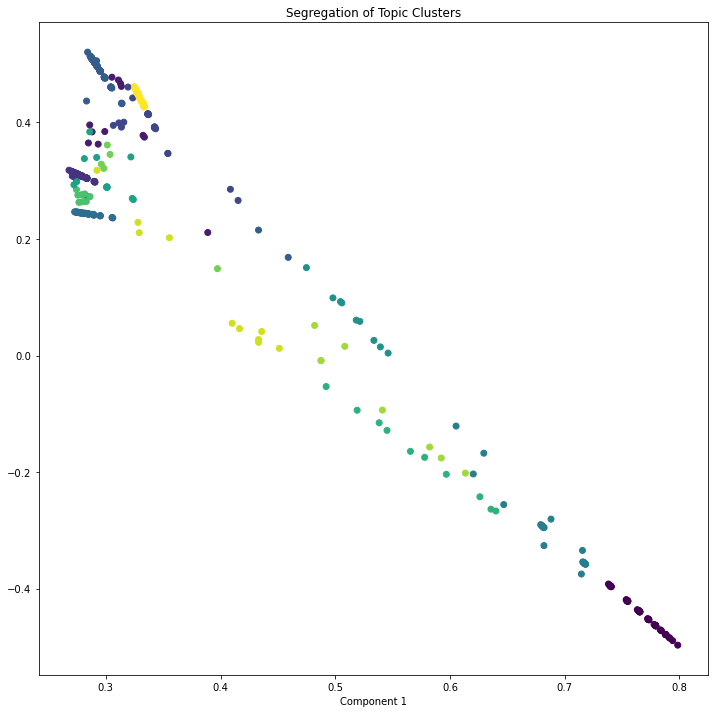

In [22]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )